<a href="https://colab.research.google.com/github/tsoares36/MVP1/blob/main/CreditScoreClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Escopo do Problema:**

Obter, a partir de um dataset com várias características (features) de clientes, o grupo (classe) a que este pertence, em relação à qualidade de crédito. São 3 grupos possíveis: 'Good' (0), 'Standard' (1) ou 'Poor' (2), fazendo referência à capacidade potencial em honrar um crédito contraído. Trata-se, portanto, de um problema de classificação multiclasse. O dataset escolhido está relativamente com boa qualidade, com bastante dados e poucas 'anomalias', entretanto, está desbalanceado. A classe 'Standard' tem muito mais registros que as demais, razão pela qual foi utilizado o algoritmo SMOTE para criar novas instâncias da classe minoritária e, consequentemente, melhorar o processo de classificação, dado que o algoritmo poderia atribuir maior peso às classes majoritárias.
Ao final do notebook, foi colocado um trecho de código que salva o modelo já treinado e pode ser 'chamado' para classificar um novo cliente. Essa parte está comentada, pois, necessita salvar o arquivo e poderia não ser executada corretamente. Ainda precisa ser melhorado, pois como são diversas features, é um pouco cansativo informá-las manualmente para obter a classificação do novo cliente.

# **Instalação e Importação de bibliotecas**

⏰*As libs datasists e category_encoders precisam ser instaladas toda vez que há desconexão do ambiente do Google Colab*

In [138]:
!pip install datasist

In [139]:
!pip install datasist category_encoders

In [140]:
# Packages for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import category_encoders as ce
import re

# Modeling and evaluation
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings
warnings.filterwarnings("ignore")

# Unbalanced data improviment
from imblearn.over_sampling import SMOTE

# Confusion Matrix
from yellowbrick.classifier import ConfusionMatrix

# Save the trained model
from joblib import dump, load

# **Ler dataset, converter para dataframe e exibir os dados**

In [141]:
dataset_url = 'https://raw.githubusercontent.com/tsoares36/MVP1/main/cred_score.csv'

In [142]:
df = pd.read_csv(dataset_url)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        80000 non-null  int64  
 1   Customer_ID               80000 non-null  int64  
 2   Month                     80000 non-null  int64  
 3   Name                      80000 non-null  object 
 4   Age                       80000 non-null  float64
 5   SSN                       80000 non-null  float64
 6   Occupation                80000 non-null  object 
 7   Annual_Income             80000 non-null  float64
 8   Monthly_Inhand_Salary     80000 non-null  float64
 9   Num_Bank_Accounts         80000 non-null  float64
 10  Num_Credit_Card           80000 non-null  float64
 11  Interest_Rate             80000 non-null  float64
 12  Num_of_Loan               80000 non-null  float64
 13  Type_of_Loan              80000 non-null  object 
 14  Delay_

In [144]:
df.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,65631.500000,26022.823700,4.500000,33.372800,4.997173e+08,50476.590536,4194.791996,5.366512,5.541350,14.560100,...,21.116025,13.317125,10.441135,5.810625,1427.878089,32.303583,220.967113,107.793302,55.063403,392.772897
std,34641.232562,14311.004791,2.291302,10.749317,2.908197e+08,38386.846333,3192.871332,2.583624,2.062715,8.737674,...,14.820270,6.233766,6.603006,3.871276,1156.913930,5.120211,99.771731,132.759193,38.963997,201.933931
min,5634.000000,1006.000000,1.000000,14.000000,4.033120e+05,7005.930000,319.556250,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.500000,0.000000,0.540000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,35632.750000,13867.500000,2.750000,25.000000,2.432650e+08,19280.227500,1626.022708,3.000000,4.000000,7.000000,...,10.000000,9.000000,5.350000,3.000000,563.100000,28.063496,144.000000,29.602331,27.893660,267.787069
50%,65631.500000,25813.000000,4.500000,33.000000,4.984100e+08,36819.645000,3073.482500,6.000000,5.000000,13.000000,...,18.000000,14.000000,9.360000,5.000000,1167.045000,32.343787,219.000000,66.736566,45.281788,333.644028
75%,95630.250000,38382.250000,6.250000,42.000000,7.561419e+08,71664.225000,5957.448333,7.000000,7.000000,20.000000,...,28.000000,18.000000,14.860000,9.000000,1953.232500,36.515261,302.000000,146.401650,71.105499,462.974892
max,125629.000000,50999.000000,8.000000,56.000000,9.999934e+08,179987.280000,15204.633333,11.000000,11.000000,34.000000,...,62.000000,25.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1779.103254,434.191089,1183.930696


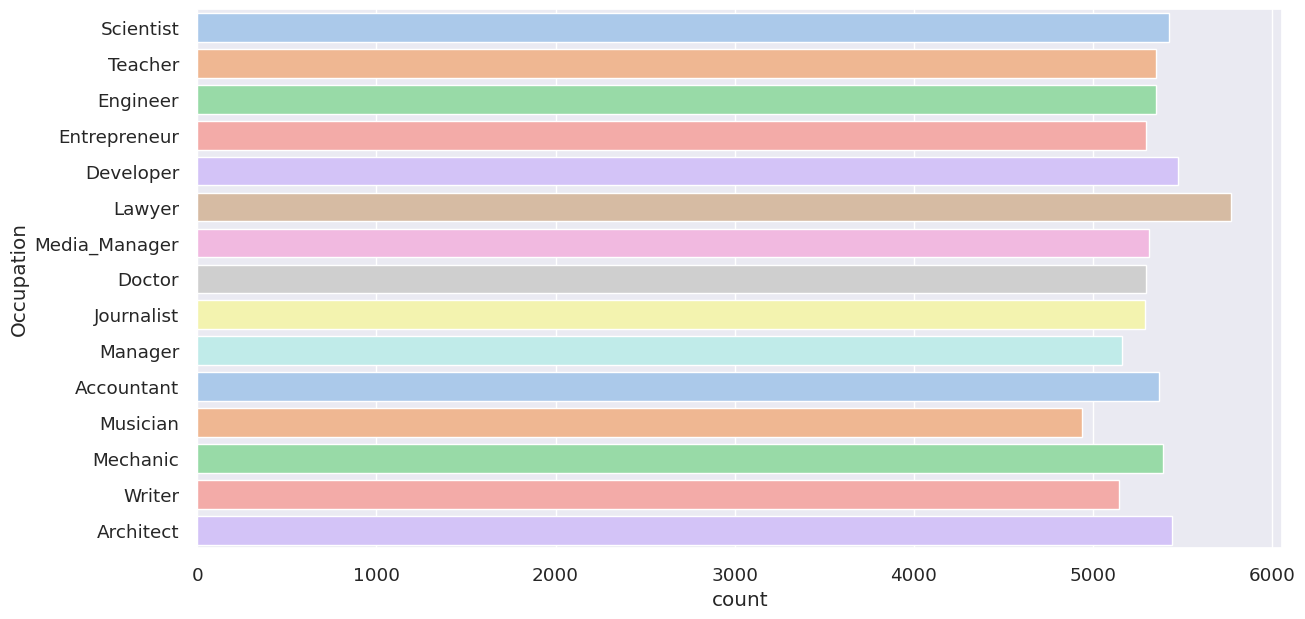

In [145]:
sns.countplot(df['Occupation'], palette="pastel");

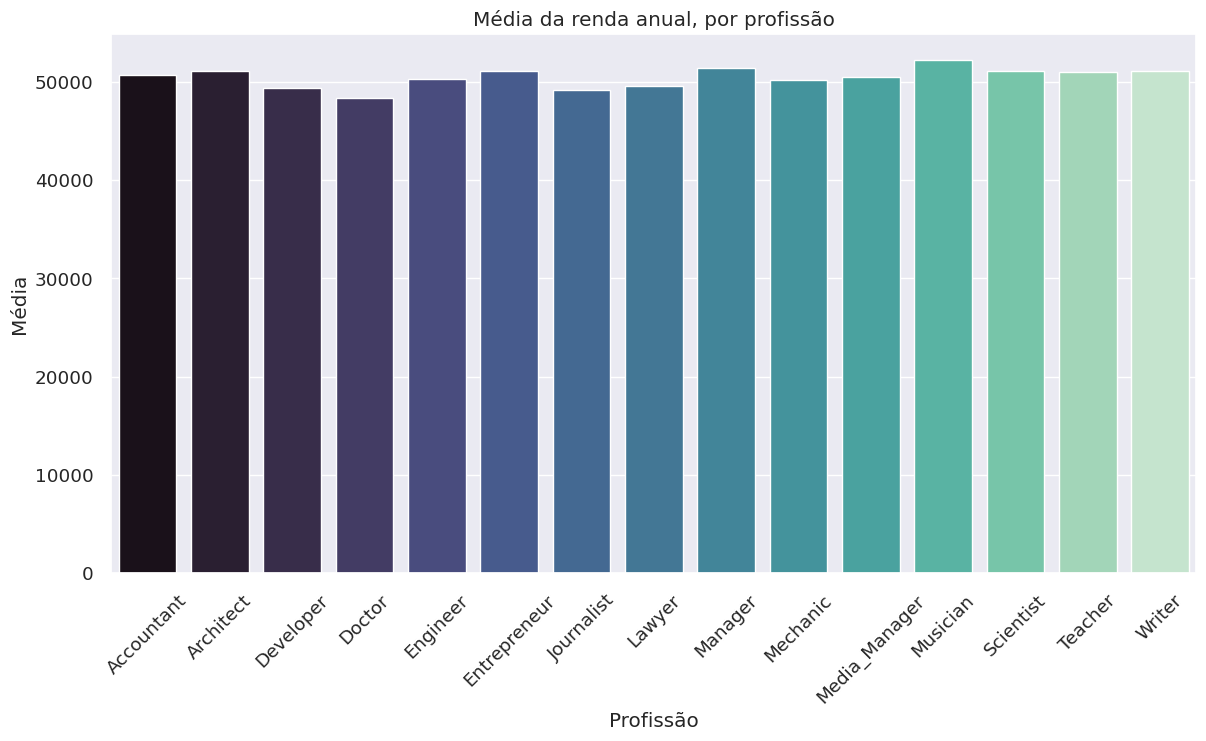

In [146]:
# média da renda anual, por profissão
mean_by_occ = df.groupby('Occupation')['Annual_Income'].mean().reset_index()

sns.barplot(data=mean_by_occ, x='Occupation', y='Annual_Income', palette='mako');
plt.xlabel('Profissão');
plt.ylabel('Média');
plt.title('Média da renda anual, por profissão');
plt.xticks(rotation=45);
plt.show();

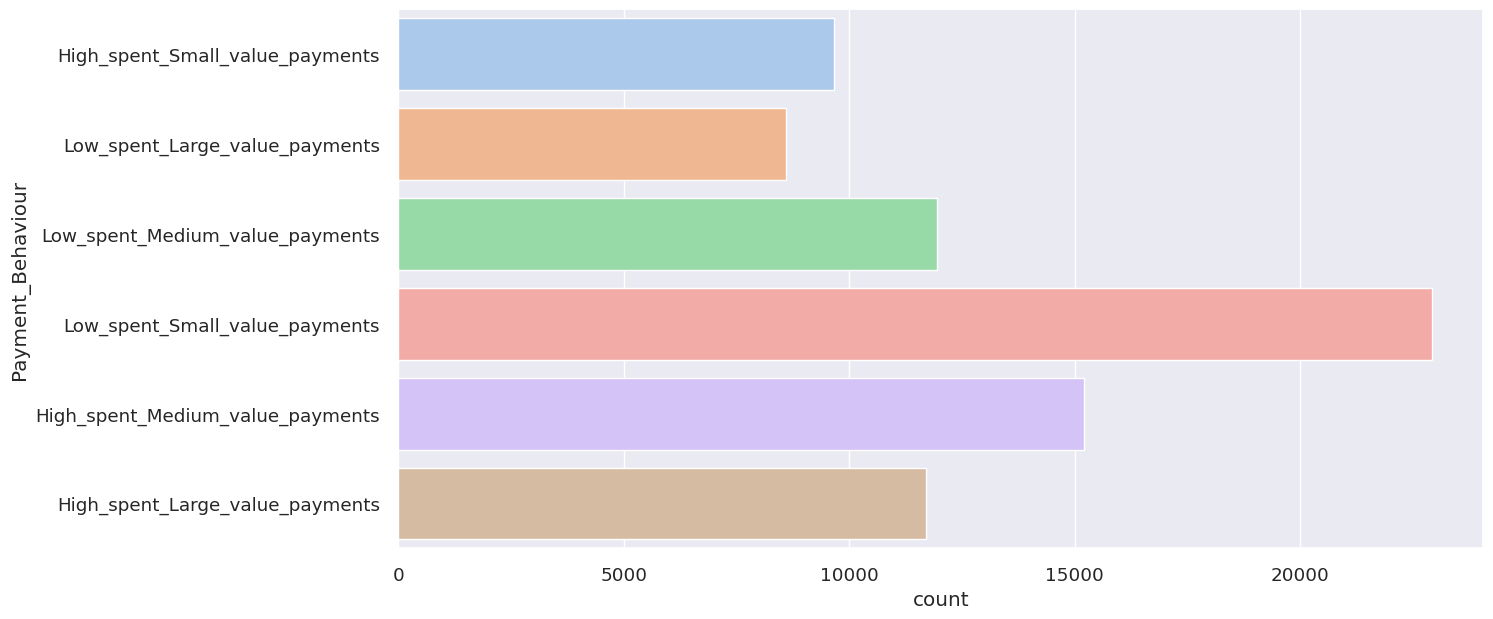

In [147]:
sns.countplot(df['Payment_Behaviour'],palette="pastel");

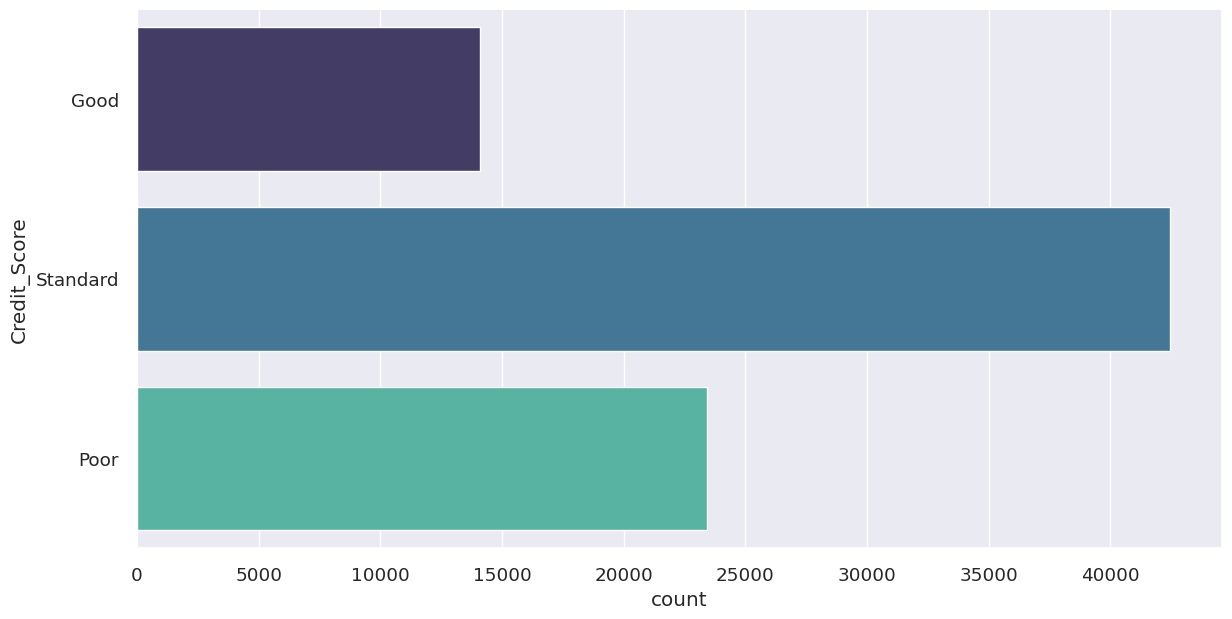

In [148]:
# Categoria de cédito do cliente (atributo classificador)
sns.countplot(df['Credit_Score'], palette="mako");

# **Pré-Processamento**

## **Limpeza dos dados**

1. Remover colunas sem utilidade para o modelo

In [149]:
df.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'], inplace=True)

2. Corrigir colunas com dados incorretos, ou em formato diferente do esperado

In [150]:
# essas colunas deveriam ter valores do tipo float
cols_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
               'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' ,
               'Monthly_Balance']

In [151]:
# A coluna Type_of_Loan (Tipo de Empréstimo) contém vários valores 'aninhados', separados por vírgula.
# É necessário transformá-la em várias colunas para facilitar a análise

for i in df['Type_of_Loan'].value_counts().head(9).index[1:]:
    df[i] = df['Type_of_Loan'].str.contains(i)

In [152]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Monthly_Balance,Credit_Score,not specified,credit-builder loan,personal loan,debt consolidation loan,mortgage loan,payday loan,auto loan,student loan
0,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,312.494089,Good,False,True,True,False,False,False,True,False
1,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,284.629162,Good,False,True,True,False,False,False,True,False
2,3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,331.209863,Good,False,True,True,False,False,False,True,False
3,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,223.451310,Good,False,True,True,False,False,False,True,False
4,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,341.489231,Good,False,True,True,False,False,False,True,False


In [153]:
# retirar a coluna Type_of_Loan
df.drop(columns=['Type_of_Loan'], inplace=True)

In [154]:
df['Credit_History_Age']

0        265.0
1        266.0
2        267.0
3        268.0
4        269.0
         ...  
79995    368.0
79996    369.0
79997    370.0
79998    371.0
79999    372.0
Name: Credit_History_Age, Length: 80000, dtype: float64

3. Substituição e alteração de tipos de valores

In [155]:
# Substituir os valores discretos Good, Standard e Poor por valores numéricos 0, 1 e 2, respectivamente

num_values = {'Good':0, 'Standard':1,'Poor':2}

def replaceCateg(x):
  x = x.replace(x, str(num_values[x]))

  return int(x)

df['Credit_Score'] = df['Credit_Score'].apply(replaceCateg)

In [156]:
# Alteração do tipo dos valores de colunas derivadas (Boolean -> int)
def changeToInt(n):
  for col in list(df.columns[-n:]):
    df[col] = df[col].astype(int)

In [157]:
# Transformar colunas com variáveis do tipo 'dummy'
df = pd.get_dummies(df,drop_first=True)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 50 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Month                                               80000 non-null  int64  
 1   Age                                                 80000 non-null  float64
 2   Annual_Income                                       80000 non-null  float64
 3   Monthly_Inhand_Salary                               80000 non-null  float64
 4   Num_Bank_Accounts                                   80000 non-null  float64
 5   Num_Credit_Card                                     80000 non-null  float64
 6   Interest_Rate                                       80000 non-null  float64
 7   Num_of_Loan                                         80000 non-null  float64
 8   Delay_from_due_date                                 80000 non-null  float64


In [159]:
# Converte valores boolean para inteiro
changeToInt(31)

In [160]:
df.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Occupation_Writer,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0,1,0,1,0,0,1,0,0,0
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,4.0,...,0,1,0,1,0,0,0,1,0,0
2,3,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0,1,0,1,0,0,0,0,1,0
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,0,1,0,1,0,0,0,0,0,1
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,0,1,0,1,0,1,0,0,0,0


In [161]:
# Atributos previsores (utilizando a base completa):
X = df.drop('Credit_Score', axis=1).values

# Classe 0 -> Good; 1 -> Standard; 2-> Poor:
y = df["Credit_Score"]

In [162]:
print(X.shape)

(80000, 49)


In [163]:
print(y.shape)

(80000,)


## **Transformação de Dados**

Balancear dados

In [164]:
# A classe 'Standard' contém muitos registros, em relação às demais.
# Utilizando os algoritmo SMOTE podemos fazer com que mais instâncias das
## classes minoritárias sejam criadas
y.value_counts(normalize=True)

Credit_Score
1    0.530987
2    0.292888
0    0.176125
Name: proportion, dtype: float64

In [165]:
y

0        0
1        0
2        0
3        0
4        0
        ..
79995    1
79996    1
79997    1
79998    1
79999    1
Name: Credit_Score, Length: 80000, dtype: int64

In [166]:
balanced_data = SMOTE(sampling_strategy='auto')
X_balanced, y_balanced = balanced_data.fit_resample(X, y)

In [167]:
y_balanced.size

127437

In [168]:
y_balanced.value_counts(normalize=True)

Credit_Score
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

## **Seleção de Características**

Aqui iremos plotar os gráficos de dispersão pré e pós oversampling (aumento das instâncias das classes minoritárias)

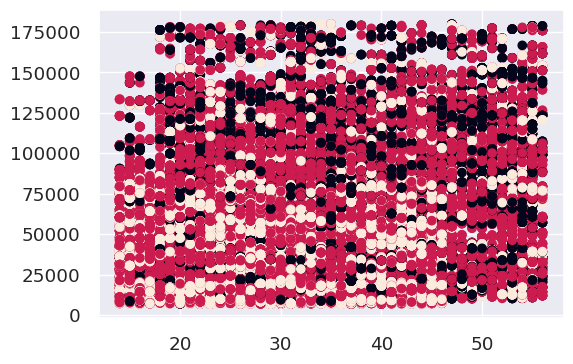

In [169]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df.Age, df.Annual_Income, c=df.Credit_Score)
plt.show()

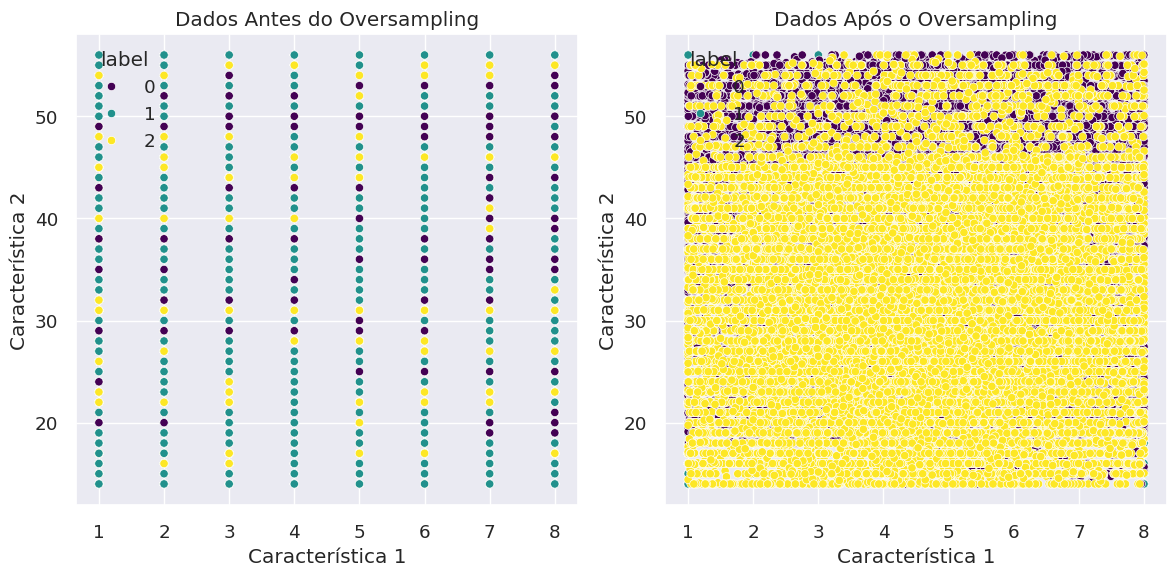

In [170]:
df_original = pd.DataFrame(X)
df_original['label'] = y

df_balanced = pd.DataFrame(X_balanced)
df_balanced['label'] = y_balanced

# Escolher as colunas para plotar
x_axis, y_axis = df_original.columns[0], df_original.columns[1]

# Criar os gráficos de dispersão
plt.figure(figsize=(12, 6))

# Gráfico para os dados originais
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
sns.scatterplot(data=df_original, x=x_axis, y=y_axis, hue='label', palette='viridis')
plt.title('Dados Antes do Oversampling')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')

# Gráfico para os dados balanceados
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
sns.scatterplot(data=df_balanced, x=x_axis, y=y_axis, hue='label', palette='viridis')
plt.title('Dados Após o Oversampling')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')

plt.tight_layout()
plt.show()

Escolher manualmente os melhores atributos (features) para o modelo pode não ser tão simples, ainda mais se houver diversas colunas no dataset. Por esse motivo, será utilizado a técnica de Feature Selection para que sejam incluídas no modelo apenas as características que melhor contribuam para o resultado

1. Verificar a variância dos dados, para cada atributo

In [171]:
# obter o menor valor de variância dos dados
min_var = []
[min_var.append(np.sqrt(X_balanced[:, i].var())) for i in range(X_balanced.shape[1])]
min_var = sorted(min_var)

In [172]:
print(round(min_var[0], 2))

0.24


In [173]:
select = VarianceThreshold(threshold=round(min_var[0], 2))

In [174]:
X_balanced_var = select.fit_transform(X_balanced)

In [175]:
# das 50 features iniciais, 30 foram descartadas
X_balanced_var.shape

(127437, 19)

Observar quais foram as features selecionadas, a partir da utilização do método acima

In [176]:
indices = np.where(select.variances_ > min_var[0])
indices

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 43]),)

In [177]:
# por fim, as colunas selecionadas como mais relevantes pelo método foram:
print(df.columns[list(indices[0])])

Index(['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Payment_of_Min_Amount_No'],
      dtype='object')


Com base nessas features selecionadas automaticamente, podemos definir um novo dataframe, com apenas essas colunas e aplicar o processamento

In [178]:
df.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Occupation_Writer,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0,1,0,1,0,0,1,0,0,0
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,4.0,...,0,1,0,1,0,0,0,1,0,0
2,3,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0,1,0,1,0,0,0,0,1,0
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,0,1,0,1,0,0,0,0,0,1
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,0,1,0,1,0,1,0,0,0,0


In [179]:
df_after_selection = df[df.columns[list(indices[0])]]

In [180]:
df_after_selection

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Payment_of_Min_Amount_No
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,26.822620,265.0,49.574949,21.465380,312.494089,1
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,4.0,11.27,4.0,809.98,31.944960,266.0,49.574949,21.465380,284.629162,1
2,3,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,28.609352,267.0,49.574949,21.465380,331.209863,1
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,6.27,4.0,809.98,31.377862,268.0,49.574949,21.465380,223.451310,1
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,11.27,4.0,809.98,24.797347,269.0,49.574949,21.465380,341.489231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,4,51.0,93589.48,7895.123333,6.0,7.0,16.0,3.0,24.0,17.0,9.92,1.0,425.51,39.820959,368.0,200.713606,84.734299,559.569595,1
79996,5,51.0,93589.48,7895.123333,6.0,7.0,16.0,3.0,26.0,17.0,9.92,1.0,425.51,35.094456,369.0,200.713606,84.734299,712.634248,1
79997,6,52.0,93589.48,7895.123333,6.0,7.0,16.0,3.0,24.0,17.0,7.92,1.0,425.51,29.232456,370.0,200.713606,84.734299,251.036700,0
79998,7,52.0,93589.48,7895.123333,6.0,7.0,16.0,3.0,24.0,17.0,9.92,6.0,425.51,37.514992,371.0,200.713606,84.734299,641.246055,1


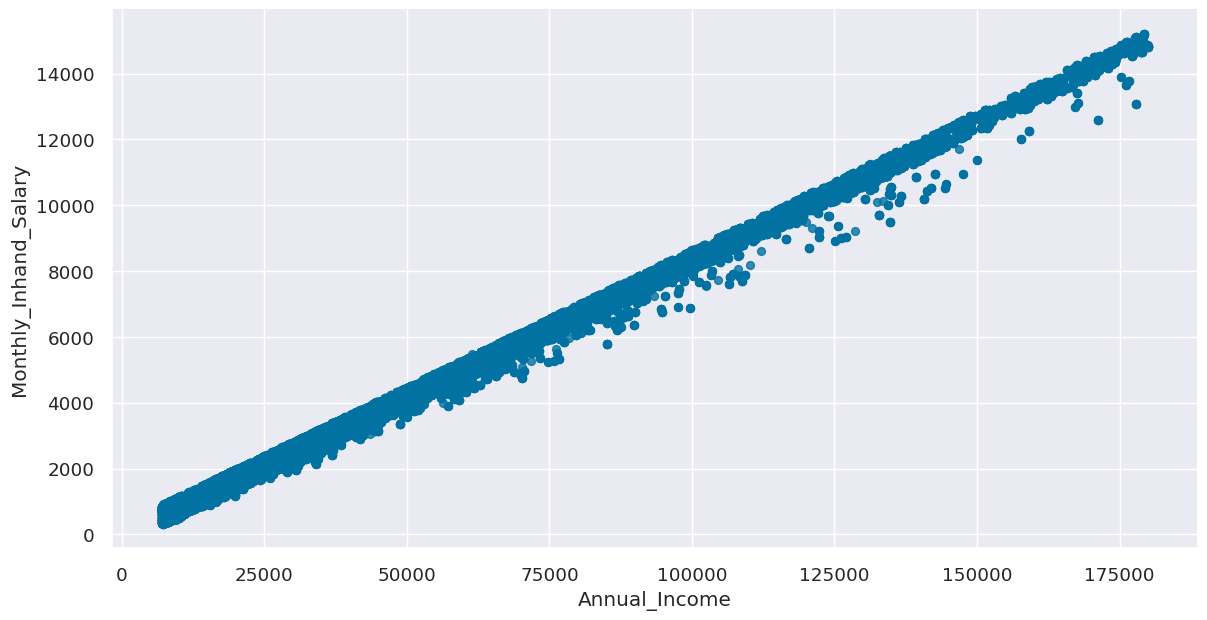

In [181]:
# @title Annual_Income vs Monthly_Inhand_Salary

df_after_selection.plot(kind='scatter', x='Annual_Income', y='Monthly_Inhand_Salary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [182]:
X_feat = df_after_selection.values

In [183]:
X_feat.shape

(80000, 19)

In [184]:
y.shape

(80000,)

Com a etapa anterior, a dimensionalidade também foi reduzida

3. Balancear base dados novamente, utilizando apenas as features selecionadas

In [185]:
balanced_data_fs = SMOTE(sampling_strategy='auto')
X_balanced_fs, y_balanced_fs = balanced_data.fit_resample(X_feat, y)

In [186]:
X_balanced_fs.shape

(127437, 19)

In [187]:
y_balanced_fs.shape

(127437,)

4. Dividir base de treino e teste

In [188]:
# O sufixo 'fs' é de 'feature selection'. Já tinha sido treinado um modelo sem a utilização
# da referida técnica.
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_balanced_fs, y_balanced_fs, test_size=0.25, random_state=42, stratify=y_balanced
)

In [189]:
# Base de treino
X_train_fs.shape

(95577, 19)

In [190]:
# Base de teste
X_test_fs.shape

(31860, 19)

4. Padronização de dados

In [191]:
# padronizar base de treino das features selecionadas pelo algoritmo
standardisation_fs = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train_fs)

In [192]:
X_train_std_fs = standardisation_fs.transform(X_train_fs)
X_test_std_fs = standardisation_fs.transform(X_test_fs)

Bases de treino e teste com escolha manual de features

In [193]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced)

In [194]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(95577, 49)
(31860, 49)
(95577,)
(31860,)


In [195]:
standardisation = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)

In [196]:
X_train_std = standardisation.transform(X_train)
X_test_std = standardisation.transform(X_test)

# **Avaliação e ecolha dos modelos**

In [197]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

In [198]:
# Com o StackingClassifier é possível combinar diversos algoritmos de
## classificação, o que pode aumentar a precisão do modelo de ML
model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

Vamos avaliar o modelo com a seleção manual de features

In [199]:
model.fit(X_train_std, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   n_jobs=-1)

In [200]:
y_pred = model.predict(X_test_std)

In [201]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     10749
           1       0.82      0.85      0.83     10323
           2       0.90      0.89      0.89     10788

    accuracy                           0.88     31860
   macro avg       0.88      0.88      0.88     31860
weighted avg       0.88      0.88      0.88     31860



In [202]:
conf_matrix = ConfusionMatrix(model.fit(X_train, y_train))

0.8826428123038292

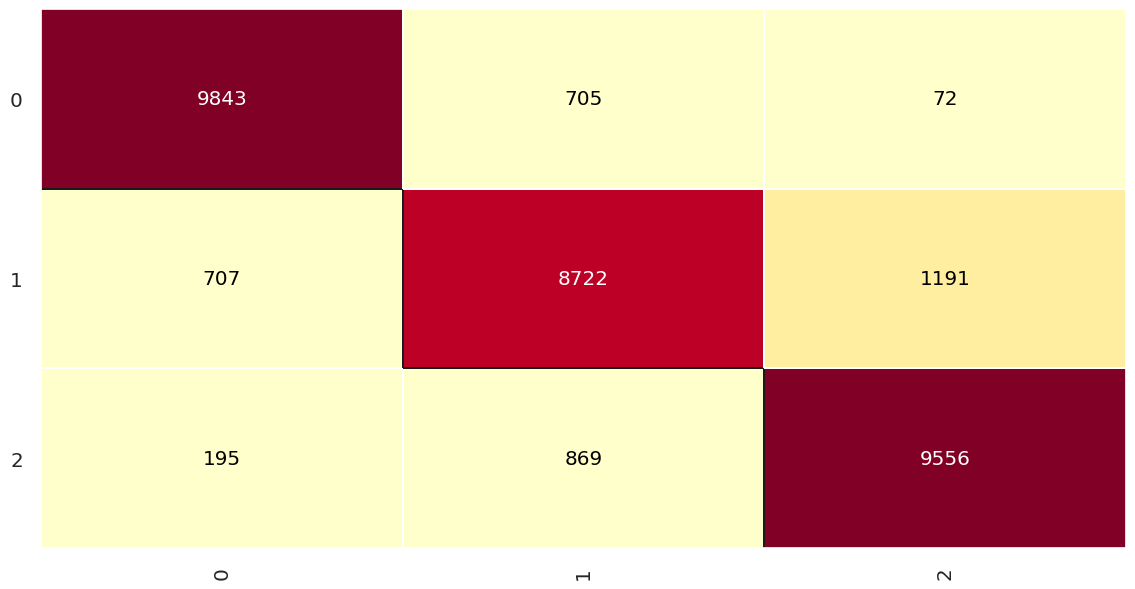

In [203]:
# Good-> 0, Standard-> 1, Poor -> 2

conf_matrix.fit(X_train, y_train)
conf_matrix.score(X_test, y_test)

Vamos avaliar o modelo com a seleção 'automática' de features, baseada na variância dos dados

In [204]:
bagging_fs = BaggingClassifier(n_jobs=-1)
extraTrees_fs = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest_fs = RandomForestClassifier(n_jobs=-1)
histGradientBoosting_fs = HistGradientBoostingClassifier()
XGB_fs = XGBClassifier(n_jobs=-1)

In [205]:
# Com o StackingClassifier é possível combinar diversos algoritmos de
## classificação, o que pode aumentar a precisão do modelo de ML
model_fs = StackingClassifier([
    ('bagging', bagging_fs),
    ('extraTress', extraTrees_fs),
    ('randomforest', randomForest_fs),
    ('histGradientBoosting', histGradientBoosting_fs),
    ('XGB', XGB_fs)
], n_jobs=-1)

In [206]:
model_fs.fit(X_train_std_fs, y_train_fs)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   n_jobs=-1)

In [207]:
X_test_std_fs.shape

(31860, 19)

In [208]:
y_pred_fs = model_fs.predict(X_test_std_fs)

In [209]:
print(classification_report(y_pred_fs, y_test_fs))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10790
           1       0.82      0.86      0.84     10137
           2       0.91      0.89      0.90     10933

    accuracy                           0.89     31860
   macro avg       0.89      0.89      0.89     31860
weighted avg       0.89      0.89      0.89     31860



In [211]:
conf_matrix_fs = ConfusionMatrix(model.fit(X_train_std_fs, y_train_fs))

0.8887633396107972

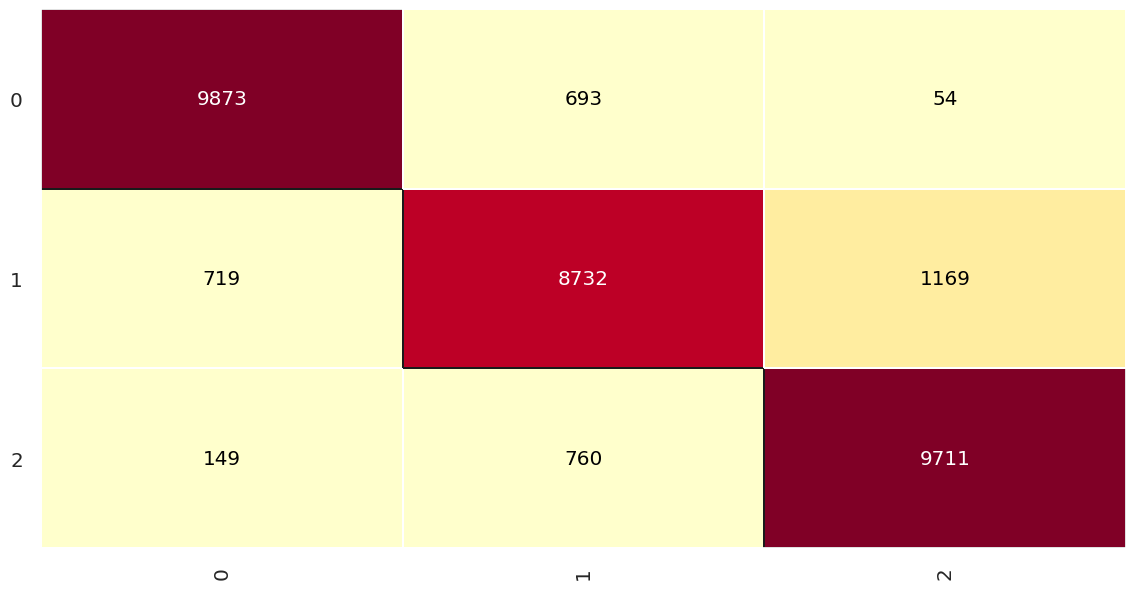

In [212]:
conf_matrix_fs.fit(X_train_std_fs, y_train_fs)
conf_matrix_fs.score(X_test_std_fs, y_test_fs)

Comparando os scores (seleção manual e seleção automática de features)

In [213]:
print("Seleção Manual:")
print(classification_report(y_pred, y_test))
print('----------------------------------------------------------')
print("Feature Selection:")
print(classification_report(y_pred_fs, y_test_fs))

Seleção Manual:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     10749
           1       0.82      0.85      0.83     10323
           2       0.90      0.89      0.89     10788

    accuracy                           0.88     31860
   macro avg       0.88      0.88      0.88     31860
weighted avg       0.88      0.88      0.88     31860

----------------------------------------------------------
Feature Selection:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10790
           1       0.82      0.86      0.84     10137
           2       0.91      0.89      0.90     10933

    accuracy                           0.89     31860
   macro avg       0.89      0.89      0.89     31860
weighted avg       0.89      0.89      0.89     31860



# **Avaliação geral do modelo e classificação de novos dados**

Analisando a Matriz de Confusão (eixo y -> classes reais; eixo x -> classes preditas) e o Classification Report, podemos ver que o modelo tem uma taxa de acerto bem alta. No entanto, há algumas falhas principalmente nas classificações 'críticas', por exemplo, ao rotular um crédito ruim (poor) como bom ('good) ou, ainda, um crédito regular (standard) como bom.
Comparando as duas matrizes, isto é, a que foi obtida a partir da seleção manual das features com a obtida automaticamente, vemos que, para este caso específico, no geral não houve melhora tão expressiva, porém, houve melhora na classificação de créditos ruins ou regulares como bons.
Pela taxa de acerto apresentada nas bases de teste, podemos também inferir que não houve assimilação demasiada aos dados, 'overfitting' e nem o inverso, 'underfitting', representando que o modelo foi satisfatório para a resolução do problema fornecido

## **Gravar e carregar modelo treinado para novas classificações**

Esse trecho de código ficará comentado, pois exige interação do usuário para prosseguir

In [ ]:
# dump(model, 'trained_model.joblib')

In [ ]:
# model_loaded = joblib.load('trained_model.joblib')

In [ ]:
# Essa parte do código irá solicitar ao usuário que preencha cada uma das features (20, no total)
# Seria interessante colocar numa interface gráfica (streamlit, por exemplo) que pudesse diminuir o esforço de imputar os dados
"""
m_data = {'a':[1]}

# for col in df.columns.to_list():
  m_data[col] = input(f"Informe: {col} ")

new_df = pd.DataFrame(m_data)
new_df.drop(columns=['a'], inplace=True)
"""

In [ ]:
# new_df.head()

In [ ]:
# X_pred = new_df.drop('Customer_ID', axis=1).values

In [ ]:
# X_pred

In [ ]:
# prediction = model_loaded.predict(X_pred)

In [ ]:
# Classificação gerada pelo algoritmo 1 -> standard
# prediction